# Forecasting crime with Facebook Prophet

#### 1. Import libraries and data

In [1]:
import pandas as pd 
import numpy as np 


from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

from prophet import Prophet 
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt 
%matplotlib inline

import itertools

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

import holidays

import plotly.graph_objs as go

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot
plt.style.use('fivethirtyeight')

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the data
df = pd.read_csv('lrpd-clean.csv')

#### 2. Reducing memory helps us do feature engineering faster and more efficiently

In [3]:
# Reduce memory like we did in data cleanup
def reduce_mem_usage(df, category=False):
  start_mem = df.memory_usage().sum() / 1024 **2
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

  for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
      c_min = df[col].min()
      c_max = df[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)
      else:
        if c_min  > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
          df[col] = df[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)
    else:
      if category:
        df[col] = df[col].astype('category')

  end_mem = df.memory_usage().sum() / 1024 ** 2
  print('Memory usage after optimizations: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
  return df

df = reduce_mem_usage(df)

Memory usage of dataframe is 10.60 MB
Memory usage after optimizations: 5.47 MB
Decreased by 48.4%


#### 3. Set correct data types

In [4]:
df["INCIDENT_DATE"] = pd.to_datetime(df["INCIDENT_DATE"])
df.dtypes

INCIDENT_NUMBER                object
INCIDENT_DATE          datetime64[ns]
LOCATION_DISTRICT             float16
OFFENSE_DESCRIPTION            object
WEAPON_TYPE                    object
ZIP                           float32
LATITUDE                      float16
LONGITUDE                     float16
WEEK_OF_MONTH                    int8
YEAR                            int16
DAY                              int8
DAY_OF_YEAR                     int16
MONTH                            int8
CRIME_TYPE                     object
RISK_TYPE                      object
RISK_TYPE_BC                     int8
dtype: object

#### 4. Prophet takes a dataframe with two columns: ds and y.
* The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.
*  The y column must be numeric, and represents the measurement we wish to forecast.

In [5]:
df = df.groupby(pd.Grouper(key='INCIDENT_DATE', freq='D')).size().reset_index(name='INCIDENT_COUNT')
df.columns = ['ds', 'y']

In [6]:
len(df)

2242

#### 5. Make a baseline model using Prophet to see how well the model does without adding regressors, holidays or hyperparameter tuning.

In [7]:

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Initialize and fit the model on the train set
m = Prophet()
m.fit(train_df)

# Make predictions for the train and test sets
future_train = m.make_future_dataframe(periods=len(train_df))
forecast_train = m.predict(future_train)

future_test = m.make_future_dataframe(periods=len(test_df))
forecast_test = m.predict(future_test)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

# Evaluate performance on the test set
y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_baseline = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print("Test RMSE:", rmse_test_baseline)


09:44:58 - cmdstanpy - INFO - Chain [1] start processing
09:44:58 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.74044614071794
Test RMSE: 9.09809956126226


#### 6. Lets add holidays to the model to see how well it does.

In [8]:
# After zooming into the data, we see that arround christmas and 4th of july, we have an affect because of the holidays.
christmas = pd.DataFrame({'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24', '2021-12-24', '2022-12-24']),
  'lower_window': -2,
  'upper_window': 5,
})

fourth_of_july = pd.DataFrame({'holiday': 'Fourth of July',
    'ds': pd.to_datetime(['2017-07-04','2018-07-04','2019-07-04','2020-07-04', '2021-07-04', '2022-07-04']),
    'lower_window': -1,
    'upper_window': 1,
})

m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True, holidays=christmas)
m.add_country_holidays(country_name='US')
m.fit(train_df)

future_train = m.make_future_dataframe(periods=len(train_df))
forecast_train = m.predict(future_train)

future_test = m.make_future_dataframe(periods=len(test_df))
forecast_test = m.predict(future_test)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

# Evaluate performance on the test set
y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_holiday = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print("Test RMSE:", rmse_test_holiday)


09:44:59 - cmdstanpy - INFO - Chain [1] start processing
09:45:00 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.426904337553296
Test RMSE: 9.503108288453053


## Putting it all together

* Now we can start putting everything together by hyperparameter tuning, adding holidays, and eventually adding weather data as well.

In [9]:
df = pd.read_csv('lrpd-clean.csv')
df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'])
df = df.groupby(pd.Grouper(key='INCIDENT_DATE', freq='D')).size().reset_index(name='INCIDENT_COUNT')
df.columns = ['ds', 'y']
df.shape
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.1],
    'seasonality_prior_scale': [0.01, 1.0],
    'holidays_prior_scale': [0.01, 0.1],
    'seasonality_mode': ['additive', 'multiplicative'],
    'daily_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
    'holidays': [christmas, fourth_of_july],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []


In [10]:

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Define the parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.1],
    'seasonality_prior_scale': [0.01, 1.0],
    'holidays_prior_scale': [0.01, 0.1],
    'seasonality_mode': ['additive', 'multiplicative'],
    'daily_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
    'holidays': [christmas, fourth_of_july],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    m = Prophet(**params).fit(train_df)

    future_train = m.make_future_dataframe(periods=len(train_df))
    forecast_train = m.predict(future_train)

    future_test = m.make_future_dataframe(periods=len(test_df))
    forecast_test = m.predict(future_test)

    # Evaluate performance on the train set
    y_true_train = train_df['y'].values
    y_pred_train = forecast_train['yhat'].values[:len(train_df)]
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

    # Evaluate performance on the test set
    y_true_test = test_df['y'].values
    y_pred_test = forecast_test['yhat'].values[-len(test_df):]
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

    rmses.append(rmse_test)

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)


09:45:01 - cmdstanpy - INFO - Chain [1] start processing
09:45:01 - cmdstanpy - INFO - Chain [1] done processing
09:45:02 - cmdstanpy - INFO - Chain [1] start processing
09:45:02 - cmdstanpy - INFO - Chain [1] done processing
09:45:03 - cmdstanpy - INFO - Chain [1] start processing
09:45:03 - cmdstanpy - INFO - Chain [1] done processing
09:45:04 - cmdstanpy - INFO - Chain [1] start processing
09:45:04 - cmdstanpy - INFO - Chain [1] done processing
09:45:05 - cmdstanpy - INFO - Chain [1] start processing
09:45:05 - cmdstanpy - INFO - Chain [1] done processing
09:45:06 - cmdstanpy - INFO - Chain [1] start processing
09:45:06 - cmdstanpy - INFO - Chain [1] done processing
09:45:07 - cmdstanpy - INFO - Chain [1] start processing
09:45:07 - cmdstanpy - INFO - Chain [1] done processing
09:45:08 - cmdstanpy - INFO - Chain [1] start processing
09:45:08 - cmdstanpy - INFO - Chain [1] done processing
09:45:09 - cmdstanpy - INFO - Chain [1] start processing
09:45:09 - cmdstanpy - INFO - Chain [1]

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale   
0                      0.001                     0.01                  0.01  \
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.01   
3                      0.001                     0.01                  0.01   
4                      0.001                     0.01                  0.01   
..                       ...                      ...                   ...   
251                    0.100                     1.00                  0.10   
252                    0.100                     1.00                  0.10   
253                    0.100                     1.00                  0.10   
254                    0.100                     1.00                  0.10   
255                    0.100                     1.00                  0.10   

    seasonality_mode  daily_seasonality  weekly_sea

In [ ]:
best_params

#### We fit the model with the best parameters, and the holidays data.

In [14]:
m = Prophet(**best_params)
m.add_country_holidays(country_name='US')

m.fit(train_df)

# df_cv = cross_validation(m, initial = '2000 days', period = '60 days', horizon='7 days', parallel="processes")
# df_p = performance_metrics(df_cv, rolling_window=1)

future_train = m.make_future_dataframe(periods=len(train_df))
forecast_train = m.predict(future_train)

future_test = m.make_future_dataframe(periods=len(test_df))
forecast_test = m.predict(future_test)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

# Evaluate performance on the test set
y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_tuned = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print("Test RMSE:", rmse_test_tuned)


09:49:18 - cmdstanpy - INFO - Chain [1] start processing
09:49:19 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.51022674677437
Test RMSE: 9.034665216311375


#### We add weather data from the local Little Rock airport weather station to the model

It is important to note that we will also need the weather data for the future in order to make forecasts on the future. 

We can obtain that data by using a weather data API to get the weather forecast for the horizon.

In [15]:
weather = pd.read_csv('weather.csv')
best_data = weather[weather['NAME'] == 'LITTLE ROCK AIRPORT ADAMS FIELD, AR US']
columns_to_keep = ['DATE', 'AWND', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN']
best_data = best_data[columns_to_keep]
best_data.fillna(0, inplace=True)
best_data = best_data[best_data['DATE'] < '2023-02-21']
best_data['DATE'] = pd.to_datetime(best_data['DATE'])
best_df = pd.merge(df, best_data, left_on='ds', right_on='DATE', how='inner')
best_df.drop(columns=['DATE'], inplace=True)

In [16]:
best_df.head()

,ds,y,AWND,PRCP,SNWD,SNOW,TMAX,TMIN
0,2017-01-01,54,6.93,0.01,0.0,0.0,46.0,43.0
1,2017-01-02,45,5.37,0.20,0.0,0.0,56.0,45.0
2,2017-01-03,49,7.61,0.00,0.0,0.0,57.0,40.0
3,2017-01-04,48,9.62,0.00,0.0,0.0,41.0,26.0
4,2017-01-05,39,8.50,0.00,0.0,0.0,37.0,29.0


Perform hyperparameter tuning after added regressors too. 

In [19]:
finalDf = best_df.copy()
list2 = ['AWND', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN']
estimator = Ridge()
selector = RFECV(estimator, step=10, cv=10)
selector = selector.fit(finalDf[list2], finalDf['y'])
to_keep = finalDf[list2].columns[selector.support_]

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.1],
    'seasonality_prior_scale': [0.01, 1.0],
    'holidays_prior_scale': [0.01, 0.1],
    'seasonality_mode': ['additive', 'multiplicative'],
    'daily_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
    'holidays': [christmas, fourth_of_july],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:

    m = Prophet(**params)
    m.add_country_holidays(country_name='US')

    # Add regressors to the dataframe
    for f in to_keep:
        df[f] = finalDf[f]
        m.add_regressor(f)

    train_size = int(len(df) * 0.8)
    train_df = df[:train_size]
    test_df = df[train_size:]

    m.fit(train_df)

    future_train = train_df.drop(columns=['y']).copy()
    for f in to_keep:
        future_train[f] = finalDf[f][:train_size]

    forecast_train = m.predict(future_train)

    # Evaluate performance on the train set
    y_true_train = train_df['y'].values
    y_pred_train = forecast_train['yhat'].values[:len(train_df)]
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

    print("Train RMSE:", rmse_train)

    # Evaluate performance on the test set
    future_test = test_df.drop(columns=['y']).copy()
    for f in to_keep:
        future_test[f] = finalDf[f][train_size:]

    forecast_test = m.predict(future_test)

    y_true_test = test_df['y'].values
    y_pred_test = forecast_test['yhat'].values[-len(test_df):]
    rmse_test_weather = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

    rmses.append(rmse_test_weather)


# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

09:54:32 - cmdstanpy - INFO - Chain [1] start processing
09:54:32 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.866815561746212


09:54:32 - cmdstanpy - INFO - Chain [1] start processing
09:54:32 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.86293863024762


09:54:33 - cmdstanpy - INFO - Chain [1] start processing
09:54:33 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.087763926739145


09:54:33 - cmdstanpy - INFO - Chain [1] start processing
09:54:33 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.101030947992609


09:54:34 - cmdstanpy - INFO - Chain [1] start processing
09:54:34 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.202413854081765


09:54:35 - cmdstanpy - INFO - Chain [1] start processing
09:54:35 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.198769655820596


09:54:35 - cmdstanpy - INFO - Chain [1] start processing
09:54:35 - cmdstanpy - INFO - Chain [1] done processing
09:54:36 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.443497038666166


09:54:36 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.447163563587907


09:54:36 - cmdstanpy - INFO - Chain [1] start processing
09:54:36 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.820748620917902


09:54:37 - cmdstanpy - INFO - Chain [1] start processing
09:54:37 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.823947363393316


09:54:38 - cmdstanpy - INFO - Chain [1] start processing
09:54:38 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.058180630069986


09:54:38 - cmdstanpy - INFO - Chain [1] start processing
09:54:38 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.065731275914668


09:54:39 - cmdstanpy - INFO - Chain [1] start processing
09:54:39 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.19074549286558


09:54:39 - cmdstanpy - INFO - Chain [1] start processing
09:54:40 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.19055688239792


09:54:40 - cmdstanpy - INFO - Chain [1] start processing
09:54:40 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.42719479437356


09:54:41 - cmdstanpy - INFO - Chain [1] start processing
09:54:41 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.426444565518578


09:54:41 - cmdstanpy - INFO - Chain [1] start processing
09:54:41 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.9125811415309295


09:54:42 - cmdstanpy - INFO - Chain [1] start processing
09:54:42 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.919563775775654


09:54:43 - cmdstanpy - INFO - Chain [1] start processing
09:54:43 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.167811384732849


09:54:43 - cmdstanpy - INFO - Chain [1] start processing
09:54:43 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.176253205713627


09:54:44 - cmdstanpy - INFO - Chain [1] start processing
09:54:44 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.225634005267551


09:54:45 - cmdstanpy - INFO - Chain [1] start processing
09:54:45 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.246427718904874


09:54:45 - cmdstanpy - INFO - Chain [1] start processing
09:54:45 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.46039932179616


09:54:46 - cmdstanpy - INFO - Chain [1] start processing
09:54:46 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.479415255530082


09:54:46 - cmdstanpy - INFO - Chain [1] start processing
09:54:46 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.9139545239089735


09:54:47 - cmdstanpy - INFO - Chain [1] start processing
09:54:47 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.881319757371872


09:54:47 - cmdstanpy - INFO - Chain [1] start processing
09:54:47 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.093222441973417


09:54:48 - cmdstanpy - INFO - Chain [1] start processing
09:54:48 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.116797491568072


09:54:49 - cmdstanpy - INFO - Chain [1] start processing
09:54:49 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.260359247296513


09:54:49 - cmdstanpy - INFO - Chain [1] start processing
09:54:49 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.26407619715348


09:54:50 - cmdstanpy - INFO - Chain [1] start processing
09:54:50 - cmdstanpy - INFO - Chain [1] done processing
09:54:50 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.417055160015662


09:54:51 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.422315105238827


09:54:51 - cmdstanpy - INFO - Chain [1] start processing
09:54:51 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.816107159770315


09:54:52 - cmdstanpy - INFO - Chain [1] start processing
09:54:52 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.825591002071609


09:54:52 - cmdstanpy - INFO - Chain [1] start processing
09:54:52 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.078708954471734


09:54:53 - cmdstanpy - INFO - Chain [1] start processing
09:54:53 - cmdstanpy - INFO - Chain [1] done processing
09:54:53 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.092748910641783


09:54:54 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.193678948943


09:54:54 - cmdstanpy - INFO - Chain [1] start processing
09:54:54 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.191489941056005


09:54:55 - cmdstanpy - INFO - Chain [1] start processing
09:54:55 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.426679694063122


09:54:55 - cmdstanpy - INFO - Chain [1] start processing
09:54:55 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.464980084864004


09:54:56 - cmdstanpy - INFO - Chain [1] start processing
09:54:56 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.810354615900057


09:54:56 - cmdstanpy - INFO - Chain [1] start processing
09:54:56 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.80824275872464


09:54:57 - cmdstanpy - INFO - Chain [1] start processing
09:54:57 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.058381603892386


09:54:58 - cmdstanpy - INFO - Chain [1] start processing
09:54:58 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.061015079039398


09:54:58 - cmdstanpy - INFO - Chain [1] start processing
09:54:58 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.17792525558989


09:54:59 - cmdstanpy - INFO - Chain [1] start processing
09:54:59 - cmdstanpy - INFO - Chain [1] done processing
09:54:59 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.200568657277643


09:54:59 - cmdstanpy - INFO - Chain [1] done processing
09:55:00 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.432106999926074


09:55:00 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.420178394757562


09:55:00 - cmdstanpy - INFO - Chain [1] start processing
09:55:01 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.868432123310382


09:55:01 - cmdstanpy - INFO - Chain [1] start processing
09:55:01 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.883659269821776


09:55:02 - cmdstanpy - INFO - Chain [1] start processing
09:55:02 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.150732853375592


09:55:02 - cmdstanpy - INFO - Chain [1] start processing
09:55:02 - cmdstanpy - INFO - Chain [1] done processing
09:55:03 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.170688299978794


09:55:03 - cmdstanpy - INFO - Chain [1] done processing
09:55:03 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.248338526867434


09:55:04 - cmdstanpy - INFO - Chain [1] done processing
09:55:04 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.226783802358282


09:55:04 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.433807702228743


09:55:05 - cmdstanpy - INFO - Chain [1] start processing
09:55:05 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.439240874654


09:55:05 - cmdstanpy - INFO - Chain [1] start processing
09:55:05 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.883724827524053


09:55:06 - cmdstanpy - INFO - Chain [1] start processing
09:55:06 - cmdstanpy - INFO - Chain [1] done processing
09:55:06 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.919021203156128


09:55:07 - cmdstanpy - INFO - Chain [1] done processing
09:55:07 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.136228409961905


09:55:07 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.128347351341937


09:55:08 - cmdstanpy - INFO - Chain [1] start processing
09:55:08 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.247190600720456


09:55:08 - cmdstanpy - INFO - Chain [1] start processing
09:55:08 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.262562070434548


09:55:09 - cmdstanpy - INFO - Chain [1] start processing
09:55:09 - cmdstanpy - INFO - Chain [1] done processing
09:55:09 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.421604866569286


09:55:09 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.423330867013512


09:55:10 - cmdstanpy - INFO - Chain [1] start processing
09:55:10 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.807414797475727


09:55:11 - cmdstanpy - INFO - Chain [1] start processing
09:55:11 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.8183243332890875


09:55:11 - cmdstanpy - INFO - Chain [1] start processing
09:55:11 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.074284769145706


09:55:12 - cmdstanpy - INFO - Chain [1] start processing
09:55:12 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.06730589269901


09:55:12 - cmdstanpy - INFO - Chain [1] start processing
09:55:13 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.220159168196414


09:55:13 - cmdstanpy - INFO - Chain [1] start processing
09:55:13 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.218432561009358


09:55:14 - cmdstanpy - INFO - Chain [1] start processing
09:55:14 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.420622022462355


09:55:14 - cmdstanpy - INFO - Chain [1] start processing
09:55:14 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.423621851286063


09:55:15 - cmdstanpy - INFO - Chain [1] start processing
09:55:15 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.812179459570162


09:55:16 - cmdstanpy - INFO - Chain [1] start processing
09:55:16 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.82153259489387


09:55:16 - cmdstanpy - INFO - Chain [1] start processing
09:55:16 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.055309948216847


09:55:17 - cmdstanpy - INFO - Chain [1] start processing
09:55:17 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.061137732123216


09:55:17 - cmdstanpy - INFO - Chain [1] start processing
09:55:17 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.182890595458607


09:55:18 - cmdstanpy - INFO - Chain [1] start processing
09:55:18 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.184857435522327


09:55:19 - cmdstanpy - INFO - Chain [1] start processing
09:55:19 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.42719479437356


09:55:19 - cmdstanpy - INFO - Chain [1] start processing
09:55:19 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.426444565518578


09:55:20 - cmdstanpy - INFO - Chain [1] start processing
09:55:20 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.853610616447274


09:55:20 - cmdstanpy - INFO - Chain [1] start processing
09:55:20 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.85558050319769


09:55:21 - cmdstanpy - INFO - Chain [1] start processing
09:55:21 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.085211498285181


09:55:22 - cmdstanpy - INFO - Chain [1] start processing
09:55:22 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.084544703325069


09:55:22 - cmdstanpy - INFO - Chain [1] start processing
09:55:22 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.191802523828008


09:55:23 - cmdstanpy - INFO - Chain [1] start processing
09:55:23 - cmdstanpy - INFO - Chain [1] done processing
09:55:24 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.192445898065062


09:55:24 - cmdstanpy - INFO - Chain [1] done processing
09:55:24 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.48996597486035


09:55:24 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.481560959584735


09:55:25 - cmdstanpy - INFO - Chain [1] start processing
09:55:25 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.871278189646647


09:55:25 - cmdstanpy - INFO - Chain [1] start processing
09:55:25 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.868171834874071


09:55:26 - cmdstanpy - INFO - Chain [1] start processing
09:55:26 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.101922750050138


09:55:27 - cmdstanpy - INFO - Chain [1] start processing
09:55:27 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.174569081028137


09:55:27 - cmdstanpy - INFO - Chain [1] start processing
09:55:27 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.224870482790026


09:55:28 - cmdstanpy - INFO - Chain [1] start processing
09:55:28 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.213493290776531


09:55:28 - cmdstanpy - INFO - Chain [1] start processing
09:55:28 - cmdstanpy - INFO - Chain [1] done processing
09:55:29 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.417055160015662


09:55:29 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.422315105238827


09:55:30 - cmdstanpy - INFO - Chain [1] start processing
09:55:30 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.804060333125296


09:55:30 - cmdstanpy - INFO - Chain [1] start processing
09:55:30 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.806065036608257


09:55:31 - cmdstanpy - INFO - Chain [1] start processing
09:55:31 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.05774371673748


09:55:31 - cmdstanpy - INFO - Chain [1] start processing
09:55:31 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.060509683482943


09:55:32 - cmdstanpy - INFO - Chain [1] start processing
09:55:32 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.179004441073848


09:55:33 - cmdstanpy - INFO - Chain [1] start processing
09:55:33 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.189987667085065


09:55:33 - cmdstanpy - INFO - Chain [1] start processing
09:55:33 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.418203009348945


09:55:34 - cmdstanpy - INFO - Chain [1] start processing
09:55:34 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.432033136093953


09:55:35 - cmdstanpy - INFO - Chain [1] start processing
09:55:35 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.795582832983508


09:55:35 - cmdstanpy - INFO - Chain [1] start processing
09:55:35 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.801072534543089


09:55:36 - cmdstanpy - INFO - Chain [1] start processing
09:55:36 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.06575687258971


09:55:36 - cmdstanpy - INFO - Chain [1] start processing
09:55:36 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.062896768903784


09:55:37 - cmdstanpy - INFO - Chain [1] start processing
09:55:37 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.169068327389766


09:55:38 - cmdstanpy - INFO - Chain [1] start processing
09:55:38 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.179496757209128


09:55:38 - cmdstanpy - INFO - Chain [1] start processing
09:55:38 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.432106999926074


09:55:39 - cmdstanpy - INFO - Chain [1] start processing
09:55:39 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.420178394757562


09:55:39 - cmdstanpy - INFO - Chain [1] start processing
09:55:39 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.831657255424044


09:55:40 - cmdstanpy - INFO - Chain [1] start processing
09:55:40 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.834701451232927


09:55:41 - cmdstanpy - INFO - Chain [1] start processing
09:55:41 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.09466813202526


09:55:41 - cmdstanpy - INFO - Chain [1] start processing
09:55:41 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.094054775300355


09:55:42 - cmdstanpy - INFO - Chain [1] start processing
09:55:42 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.185041055361754


09:55:43 - cmdstanpy - INFO - Chain [1] start processing
09:55:43 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.188161960310989


09:55:43 - cmdstanpy - INFO - Chain [1] start processing
09:55:43 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.435007356841696


09:55:44 - cmdstanpy - INFO - Chain [1] start processing
09:55:44 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.443812546476224


09:55:44 - cmdstanpy - INFO - Chain [1] start processing
09:55:44 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.856716782852241


09:55:45 - cmdstanpy - INFO - Chain [1] start processing
09:55:45 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.844881967867315


09:55:46 - cmdstanpy - INFO - Chain [1] start processing
09:55:46 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.109427842929717


09:55:46 - cmdstanpy - INFO - Chain [1] start processing
09:55:46 - cmdstanpy - INFO - Chain [1] done processing
09:55:47 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.155293625657595


09:55:47 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.191188120717722


09:55:47 - cmdstanpy - INFO - Chain [1] start processing
09:55:47 - cmdstanpy - INFO - Chain [1] done processing
09:55:48 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.200084502062932


09:55:48 - cmdstanpy - INFO - Chain [1] done processing
09:55:48 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.421604866569286


09:55:48 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.423330867013512


09:55:49 - cmdstanpy - INFO - Chain [1] start processing
09:55:49 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.5064061492257075


09:55:50 - cmdstanpy - INFO - Chain [1] start processing
09:55:50 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.502987082163284


09:55:51 - cmdstanpy - INFO - Chain [1] start processing
09:55:51 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.712714250346061


09:55:51 - cmdstanpy - INFO - Chain [1] start processing
09:55:51 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.7101262101409915


09:55:52 - cmdstanpy - INFO - Chain [1] start processing
09:55:52 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.88793541805174


09:55:53 - cmdstanpy - INFO - Chain [1] start processing
09:55:53 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.885371536816515


09:55:53 - cmdstanpy - INFO - Chain [1] start processing
09:55:54 - cmdstanpy - INFO - Chain [1] done processing
09:55:54 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.089147600690461


09:55:54 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.090048188152315


09:55:55 - cmdstanpy - INFO - Chain [1] start processing
09:55:55 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.501909444190343


09:55:55 - cmdstanpy - INFO - Chain [1] start processing
09:55:56 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.507122791972169


09:55:56 - cmdstanpy - INFO - Chain [1] start processing
09:55:56 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.69819282046404


09:55:57 - cmdstanpy - INFO - Chain [1] start processing
09:55:57 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.702538700750595


09:55:58 - cmdstanpy - INFO - Chain [1] start processing
09:55:58 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.889746677550238


09:55:58 - cmdstanpy - INFO - Chain [1] start processing
09:55:59 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.888612661395403


09:55:59 - cmdstanpy - INFO - Chain [1] start processing
09:55:59 - cmdstanpy - INFO - Chain [1] done processing
09:56:00 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.086843401521298


09:56:00 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.089287351947792


09:56:00 - cmdstanpy - INFO - Chain [1] start processing
09:56:01 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.553250633866479


09:56:01 - cmdstanpy - INFO - Chain [1] start processing
09:56:01 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.553622865908127


09:56:02 - cmdstanpy - INFO - Chain [1] start processing
09:56:02 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.7473423680777245


09:56:03 - cmdstanpy - INFO - Chain [1] start processing
09:56:03 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.749887263860339


09:56:03 - cmdstanpy - INFO - Chain [1] start processing
09:56:04 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.894601622903564


09:56:04 - cmdstanpy - INFO - Chain [1] start processing
09:56:04 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.897443208330071


09:56:05 - cmdstanpy - INFO - Chain [1] start processing
09:56:05 - cmdstanpy - INFO - Chain [1] done processing
09:56:05 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.083432344407331


09:56:06 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.08281308880239


09:56:06 - cmdstanpy - INFO - Chain [1] start processing
09:56:06 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.556413978118847


09:56:07 - cmdstanpy - INFO - Chain [1] start processing
09:56:07 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.560764604175266


09:56:07 - cmdstanpy - INFO - Chain [1] start processing
09:56:08 - cmdstanpy - INFO - Chain [1] done processing
09:56:08 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.742998198505309


09:56:08 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.750716186657475


09:56:09 - cmdstanpy - INFO - Chain [1] start processing
09:56:09 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.898562036577828


09:56:09 - cmdstanpy - INFO - Chain [1] start processing
09:56:10 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.898014494485937


09:56:10 - cmdstanpy - INFO - Chain [1] start processing
09:56:10 - cmdstanpy - INFO - Chain [1] done processing
09:56:11 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.0854909436702


09:56:11 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.08579235043334


09:56:12 - cmdstanpy - INFO - Chain [1] start processing
09:56:12 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.393356276807382


09:56:12 - cmdstanpy - INFO - Chain [1] start processing
09:56:12 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.417133567337501


09:56:13 - cmdstanpy - INFO - Chain [1] start processing
09:56:13 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.587180549183407


09:56:14 - cmdstanpy - INFO - Chain [1] start processing
09:56:14 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.6324947552287545


09:56:14 - cmdstanpy - INFO - Chain [1] start processing
09:56:14 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.80080970253075


09:56:15 - cmdstanpy - INFO - Chain [1] start processing
09:56:15 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.819136232467874


09:56:16 - cmdstanpy - INFO - Chain [1] start processing
09:56:16 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.003039196898342


09:56:16 - cmdstanpy - INFO - Chain [1] start processing
09:56:16 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.027978711354756


09:56:17 - cmdstanpy - INFO - Chain [1] start processing
09:56:17 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.388498055592597


09:56:18 - cmdstanpy - INFO - Chain [1] start processing
09:56:18 - cmdstanpy - INFO - Chain [1] done processing
09:56:18 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.4142763941864365


09:56:19 - cmdstanpy - INFO - Chain [1] done processing
09:56:19 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.591221174850655


09:56:19 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.628918211430887


09:56:20 - cmdstanpy - INFO - Chain [1] start processing
09:56:20 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.797933135018114


09:56:20 - cmdstanpy - INFO - Chain [1] start processing
09:56:21 - cmdstanpy - INFO - Chain [1] done processing
09:56:21 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.817622250180878


09:56:21 - cmdstanpy - INFO - Chain [1] done processing
09:56:22 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.99742651219588


09:56:22 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.031489529616277


09:56:22 - cmdstanpy - INFO - Chain [1] start processing
09:56:23 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.451472235446682


09:56:23 - cmdstanpy - INFO - Chain [1] start processing
09:56:23 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.478472727479839


09:56:24 - cmdstanpy - INFO - Chain [1] start processing
09:56:24 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.65189400453782


09:56:25 - cmdstanpy - INFO - Chain [1] start processing
09:56:25 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.686997146886405


09:56:25 - cmdstanpy - INFO - Chain [1] start processing
09:56:25 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.8175432775398965


09:56:26 - cmdstanpy - INFO - Chain [1] start processing
09:56:26 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.837980167906913


09:56:27 - cmdstanpy - INFO - Chain [1] start processing
09:56:27 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.01412136899599


09:56:27 - cmdstanpy - INFO - Chain [1] start processing
09:56:28 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.028534251365324


09:56:28 - cmdstanpy - INFO - Chain [1] start processing
09:56:28 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.457265836862609


09:56:29 - cmdstanpy - INFO - Chain [1] start processing
09:56:29 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.478262767423339


09:56:30 - cmdstanpy - INFO - Chain [1] start processing
09:56:30 - cmdstanpy - INFO - Chain [1] done processing
09:56:30 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.653679140392308


09:56:30 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.688008752257748


09:56:31 - cmdstanpy - INFO - Chain [1] start processing
09:56:31 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.817830261513049


09:56:32 - cmdstanpy - INFO - Chain [1] start processing
09:56:32 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.837285704851556


09:56:32 - cmdstanpy - INFO - Chain [1] start processing
09:56:32 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.009865709054072


09:56:33 - cmdstanpy - INFO - Chain [1] start processing
09:56:33 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.033764401676747


09:56:34 - cmdstanpy - INFO - Chain [1] start processing
09:56:34 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.494274470080874


09:56:34 - cmdstanpy - INFO - Chain [1] start processing
09:56:35 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.499527059963471


09:56:35 - cmdstanpy - INFO - Chain [1] start processing
09:56:35 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.697333475675969


09:56:36 - cmdstanpy - INFO - Chain [1] start processing
09:56:36 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.693630679995273


09:56:37 - cmdstanpy - INFO - Chain [1] start processing
09:56:37 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.884519595674751


09:56:37 - cmdstanpy - INFO - Chain [1] start processing
09:56:37 - cmdstanpy - INFO - Chain [1] done processing
09:56:38 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.8827852583956615


09:56:38 - cmdstanpy - INFO - Chain [1] done processing
09:56:38 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.088658713331514


09:56:39 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.093829170075118


09:56:39 - cmdstanpy - INFO - Chain [1] start processing
09:56:39 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.490858867124327


09:56:40 - cmdstanpy - INFO - Chain [1] start processing
09:56:40 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.494716334089037


09:56:41 - cmdstanpy - INFO - Chain [1] start processing
09:56:41 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.692887657748402


09:56:41 - cmdstanpy - INFO - Chain [1] start processing
09:56:42 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.696626203099708


09:56:42 - cmdstanpy - INFO - Chain [1] start processing
09:56:42 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.88448170776036


09:56:43 - cmdstanpy - INFO - Chain [1] start processing
09:56:43 - cmdstanpy - INFO - Chain [1] done processing
09:56:43 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.883254657519501


09:56:44 - cmdstanpy - INFO - Chain [1] done processing
09:56:44 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.086843401521298


09:56:44 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.089287351947792


09:56:45 - cmdstanpy - INFO - Chain [1] start processing
09:56:45 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.462325958292188


09:56:46 - cmdstanpy - INFO - Chain [1] start processing
09:56:46 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.465060150677316


09:56:47 - cmdstanpy - INFO - Chain [1] start processing
09:56:47 - cmdstanpy - INFO - Chain [1] done processing
09:56:48 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.598461594186142


09:56:48 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.553248152291873


09:56:49 - cmdstanpy - INFO - Chain [1] start processing
09:56:49 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.872221555332584


09:56:49 - cmdstanpy - INFO - Chain [1] start processing
09:56:50 - cmdstanpy - INFO - Chain [1] done processing
09:56:50 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.872385796758238


09:56:50 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.072376665248365


09:56:51 - cmdstanpy - INFO - Chain [1] start processing
09:56:51 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.07766443381327


09:56:51 - cmdstanpy - INFO - Chain [1] start processing
09:56:52 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.500412379651875


09:56:52 - cmdstanpy - INFO - Chain [1] start processing
09:56:52 - cmdstanpy - INFO - Chain [1] done processing
09:56:53 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.5034347182447645


09:56:53 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.715079733473338


09:56:53 - cmdstanpy - INFO - Chain [1] start processing
09:56:54 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.70694618928788


09:56:54 - cmdstanpy - INFO - Chain [1] start processing
09:56:54 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.87074987649831


09:56:55 - cmdstanpy - INFO - Chain [1] start processing
09:56:55 - cmdstanpy - INFO - Chain [1] done processing
09:56:55 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.871333343832262


09:56:56 - cmdstanpy - INFO - Chain [1] done processing
09:56:56 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.0854909436702


09:56:56 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.08579235043334


09:56:57 - cmdstanpy - INFO - Chain [1] start processing
09:56:57 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.382593680952293


09:56:58 - cmdstanpy - INFO - Chain [1] start processing
09:56:58 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.40604297465645


09:56:58 - cmdstanpy - INFO - Chain [1] start processing
09:56:58 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.59277537840499


09:56:59 - cmdstanpy - INFO - Chain [1] start processing
09:56:59 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.607758238721196


09:57:00 - cmdstanpy - INFO - Chain [1] start processing
09:57:00 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.795554532105231


09:57:01 - cmdstanpy - INFO - Chain [1] start processing
09:57:01 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.818441598746316


09:57:01 - cmdstanpy - INFO - Chain [1] start processing
09:57:01 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.001977470578701


09:57:02 - cmdstanpy - INFO - Chain [1] start processing
09:57:02 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.027124149976745


09:57:03 - cmdstanpy - INFO - Chain [1] start processing
09:57:03 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.377315647526782


09:57:03 - cmdstanpy - INFO - Chain [1] start processing
09:57:03 - cmdstanpy - INFO - Chain [1] done processing
09:57:04 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.4050818431898975


09:57:04 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.579708454639338


09:57:05 - cmdstanpy - INFO - Chain [1] start processing
09:57:05 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.615291872049456


09:57:05 - cmdstanpy - INFO - Chain [1] start processing
09:57:05 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.798109751041234


09:57:06 - cmdstanpy - INFO - Chain [1] start processing
09:57:06 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.815069331871556


09:57:07 - cmdstanpy - INFO - Chain [1] start processing
09:57:07 - cmdstanpy - INFO - Chain [1] done processing
09:57:07 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.99742651219588


09:57:08 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.031489529616277


09:57:08 - cmdstanpy - INFO - Chain [1] start processing
09:57:08 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.323384241195208


09:57:09 - cmdstanpy - INFO - Chain [1] start processing
09:57:10 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.326539925444357


09:57:10 - cmdstanpy - INFO - Chain [1] start processing
09:57:10 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.443971393570608


09:57:11 - cmdstanpy - INFO - Chain [1] start processing
09:57:11 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.44432766748742


09:57:12 - cmdstanpy - INFO - Chain [1] start processing
09:57:12 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.702376940828467


09:57:13 - cmdstanpy - INFO - Chain [1] start processing
09:57:13 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.707664552619028


09:57:14 - cmdstanpy - INFO - Chain [1] start processing
09:57:14 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.818286908753269


09:57:15 - cmdstanpy - INFO - Chain [1] start processing
09:57:15 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.819697243426248


09:57:15 - cmdstanpy - INFO - Chain [1] start processing
09:57:16 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.397808967292932


09:57:16 - cmdstanpy - INFO - Chain [1] start processing
09:57:16 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.419013403185129


09:57:17 - cmdstanpy - INFO - Chain [1] start processing
09:57:17 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.6135703727340065


09:57:18 - cmdstanpy - INFO - Chain [1] start processing
09:57:18 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.642836960846853


09:57:18 - cmdstanpy - INFO - Chain [1] start processing
09:57:18 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.790091618240651


09:57:19 - cmdstanpy - INFO - Chain [1] start processing
09:57:19 - cmdstanpy - INFO - Chain [1] done processing
09:57:20 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 7.801916086342905


09:57:20 - cmdstanpy - INFO - Chain [1] done processing
09:57:20 - cmdstanpy - INFO - Chain [1] start processing


Train RMSE: 8.009865709054072


09:57:20 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8.033764401676747
     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale   
0                      0.001                     0.01                  0.01  \
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.01   
3                      0.001                     0.01                  0.01   
4                      0.001                     0.01                  0.01   
..                       ...                      ...                   ...   
251                    0.100                     1.00                  0.10   
252                    0.100                     1.00                  0.10   
253                    0.100                     1.00                  0.10   
254                    0.100                     1.00                  0.10   
255                    0.100                     1.00                  0.10   

    seasonality_mode 

In [ ]:
best_params

Training with the best params!

In [20]:

m = Prophet(**best_params)
m.add_country_holidays(country_name='US')

# Add regressors to the dataframe
for f in to_keep:
    df[f] = finalDf[f]
    m.add_regressor(f)

train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

m.fit(train_df)

future_train = train_df.drop(columns=['y']).copy()
for f in to_keep:
    future_train[f] = finalDf[f][:train_size]

forecast_train = m.predict(future_train)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

# Evaluate performance on the test set
future_test = test_df.drop(columns=['y']).copy()
for f in to_keep:
    future_test[f] = finalDf[f][train_size:]

forecast_test = m.predict(future_test)

y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_weather = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print("Test RMSE:", rmse_test_weather)


09:57:27 - cmdstanpy - INFO - Chain [1] start processing
09:57:28 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.323384241195208
Test RMSE: 8.769440002123643


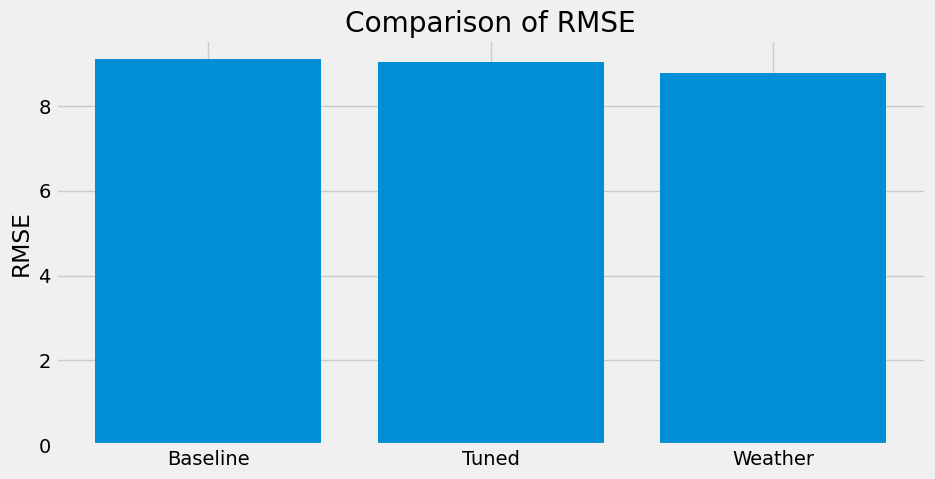

In [21]:
comparison = pd.DataFrame()
comparison['Model'] = ['Baseline', 'Holiday', 'Weather']
comparison['RMSE'] = [rmse_test_baseline, rmse_test_tuned, rmse_test_weather]
# plot the results
plt.figure(figsize=(10, 5))
plt.bar(comparison['Model'], comparison['RMSE'])
plt.title('Comparison of RMSE')
plt.ylabel('RMSE')
plt.show()